In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              40
On-line CPU(s) list: 0-39
Thread(s) per core:  2
Core(s) per socket:  20
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0-39
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd i

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install contractions

In [ ]:
# Preamble
import nltk
nltk.download('stopwords')
import string
import numpy as np
from ast import literal_eval
import shutil
import pandas as pd
import csv
import re
import random
import string
from scipy import spatial
import unicodedata
import contractions
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def unicode_to_ascii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'MN')
  
def normalize_string(s):
  s = unicode_to_ascii(s)
  # s = s.replace('NOVELTY - ','').replace('    USE -', '').replace('    ADVANTAGE -', '').replace('    DETAILED DESCRIPTION -','').replace('INDEPENDENT CLAIM','').replace(' INDEPENDENT CLAIMS','').replace('(i)','').replace('(ii)','').replace('(iii)','').replace('(iv)','').replace('(v)','').replace('(vi)','')
  # s,_,_ = s.partition('    DESCRIPTION OF DRAWING(S) -')
  s = ' '.join([contractions.fix(word) for word in s.split()])
  s = re.sub('['+string.punctuation+']', ' ', s.lower()).strip()
  s = re.sub("\s\s+" , " ", s)
  # s = ' '.join([word for word in s.split() if word not in stopwords_dict and word.isnumeric()==False])
  # s = ' '.join([word for word in s.split() if word.isalpha()])
  s = s.replace('  ',' ')
  return s

# text = normalize_string(text)
# text=re.sub("\s\s+" , " ", text)

In [ ]:
#Merging dataset
#Normalize the data and store the new files in a separate folder
# import glob
# TRAINING_DIR="/content/drive/MyDrive/AdvancedNLP/sentence-completion/Holmes_Training_Data/"
# fileList = glob.glob(TRAINING_DIR+"*.TXT")
# limit='*END*THE SMALL PRINT! FOR PUBLIC DOMAIN ETEXTS*Ver.04.29.93*END*'
# for i,f in enumerate(fileList):
#   with open(f,'r',encoding='unicode_escape') as fd:
#     text=fd.read()
#     text = text[text.find(limit)+len(limit):]
#     fout=open('/content/drive/MyDrive/AdvancedNLP/sentence-completion/holmes_training_data_infoRem/'+str(i)+'.txt','w')
#     fout.write(text)
#     fout.close()

TRAINING_DIR="/content/drive/MyDrive/AdvancedNLP/sentence-completion/holmes_training_data_infoRem/" #Load training data
fileList = glob.glob(TRAINING_DIR+"*.txt")
fileList[0]

with open('/content/drive/MyDrive/AdvancedNLP/sentence-completion/MERGED.txt','wb') as wfd: #Merge
  for f in fileList[:20]:
    with open(f,'rb') as fd:
      shutil.copyfileobj(fd, wfd)

In [ ]:
# The merged training dataset
training_data_file = '/content/drive/MyDrive/AdvancedNLP/sentence-completion/MERGED.txt'

In [ ]:
modifiestrainingSet=pd.read_csv("/content/drive/MyDrive/AdvancedNLP/sentence-completion/testing_data.csv")
modifiestrainingSet.head()

,id,question,a),b),c),d),e)
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus


In [ ]:
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

In [ ]:
#Ranking Dictionary
TFIDFDict={}
with open('/content/drive/MyDrive/AdvancedNLP/sentence-completion/MERGEDNorm.txt','r') as f:
  dataSet=f.read()
  corpora=[w for w in dataSet.split() if w not in stopwords_dict]

  vectorizer = TfidfVectorizer(min_df=80,max_df=0.7)
  X = vectorizer.fit_transform(corpora)
  sums = X.sum(axis=0)
  features = vectorizer.get_feature_names_out()
  for col, term in enumerate(features):
    TFIDFDict[term] = sums[0,col]

#Unkown smooting
TFIDFDictUNK={}
count=0
for key,value in TFIDFDict.items():
  if int(value) < 90:
    count+=1
    TFIDFDictUNK['UNK'] = TFIDFDictUNK.get('UNK',0)+value
  else:
    TFIDFDictUNK[key] = value
    
TFIDFDictUNK['UNK'] = TFIDFDictUNK.get('UNK')/count
TFIDFDictUNK['UNK']

#Saving the TFIDF Ranks
tfidfDF=pd.DataFrame(TFIDFDict.items(), columns = ['term','rank'])
tfidfDF = tfidfDF.sort_values('rank', ascending=False)
tfidfDF.head()
tfidfDF.to_csv("/content/drive/MyDrive/AdvancedNLP/sentence-completion/tokenRanksThreshold,csv")

In [ ]:
#Adding left context to the test data and saving the file
ques=list(modifiestrainingSet['question'])
normQues=[]
right_context=[]
for q in ques:
  context=[]
  tok=[w.lower().replace('-','') for w in q.split() if w!=',']
  maskidx=tok.index('_____')
  context.extend((tok[maskidx-3],tok[maskidx-2],tok[maskidx-1]))
  right_context.append(context)
  normQues.append(normalize_string(q))
  # print(context)
modifiestrainingSet['contextTri']=right_context
modifiestrainingSet.head()
modifiestrainingSet.to_csv("/content/drive/MyDrive/AdvancedNLP/sentence-completion/test_dataModifiedTri.csv")

,id,question,a),b),c),d),e),contextTri
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking,"[bachelor, and, are]"
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably,"[with, flowers, arranged]"
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance,"[old, ally, the]"
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying,"[we, got, off]"
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus,"[his, hand, a]"


In [ ]:
def add2dict(dictionary, key, value): #This function is used to add tokens that appear after the n-gram
    if key not in dictionary:
        dictionary[key] = []
    dictionary[key].append(value)

In [ ]:
def list2probabilitydict(given_list): #This function is used to extract the probabilty values from the frequency values of the tokens
    probability_dict = {}
    given_list_length = len(given_list)
    for item in given_list:
        probability_dict[item] = probability_dict.get(item, 0) + 1
    for key, value in probability_dict.items():
        probability_dict[key] = value / given_list_length
    return probability_dict

In [ ]:
#Trigrams with UNK
#TriGrams initialization
initial_word = {}
second_word = {}
third_word={}
transitions = {}
transitionsUnk={}
transitionsUnk[('UNK', 'UNK')]=[]

def train_markov_model():
    for line in open(training_data_file):
        tokens = normalize_string(line).split() #Normalize
        # print(tokens)
        tokens_length = len(tokens)
        for i in range(tokens_length):
            token = tokens[i]
            if i == 0:
                initial_word[token] = initial_word.get(token, 0) + 1 #Initial word is kept to experiment with text generation
            else:
                prev_token = tokens[i - 1] #get prev token
                if i == tokens_length - 1:
                    add2dict(transitions, (prev_token, token), 'END') #Append "END" if the final token is reached mostly used for text generation.
                if i == 1:
                    add2dict(second_word, prev_token, token) #Second work is kept to experiment with text generation. (initial words are sampled using initial_word and second_word dictionary)
                else:
                    prev_prev_token = tokens[i - 2]
                    add2dict(transitions, (prev_prev_token, prev_token), token) #All the other words in between with a sliding window implementation.
    
    #Unknown values are created according to the length of the tokens following the previous two tokens.
    for (key,value) in transitions.items():
      if (len(value)<3):
        # print(len(value),value)
        transitionsUnk[('UNK', 'UNK')].append(value[0])
      else:
        transitionsUnk[key]=value
    
    # Normalize the distributions
    initial_word_total = sum(initial_word.values())
    for key, value in initial_word.items():
        initial_word[key] = value / initial_word_total
        
    for prev_word, next_word_list in second_word.items():
        second_word[prev_word] = list2probabilitydict(next_word_list)
        
    for word_pair, next_word_list in transitionsUnk.items():
        transitionsUnk[word_pair] = list2probabilitydict(next_word_list)
    
    print('Training successful.')

In [ ]:
#quad-grams with UNK working same as trigrams with an addition of an extra token in the sliding window implementation
#QuadGrams initialize
initial_word = {}
second_word = {}
third_word={}
transitions = {}
transitionsUnk={}
transitionsUnk[('UNK', 'UNK', 'UNK')]=[]
def train_markov_model():
    for line in open(training_data_file):
        tokens = normalize_string(line).split()
        # print(tokens)
        tokens_length = len(tokens)
        for i in range(tokens_length):
            token = tokens[i]
            if i == 0:
                initial_word[token] = initial_word.get(token, 0) + 1
            else:
                prev_token = tokens[i - 1]
                # prev_prev_token=''
                if i == tokens_length - 1:
                    prev_prev_token = tokens[i - 2]
                    add2dict(transitions, (prev_prev_token, prev_token, token), 'END')
                if i == 1:
                    add2dict(second_word, prev_token, token)
                if i == 2:
                    prev_prev_token = tokens[i - 2]
                    add2dict(third_word, prev_prev_token, token)
                else:
                    prev_prev_token = tokens[i - 2]
                    prev_prev_prev_token = tokens[i - 3]
                    add2dict(transitions, (prev_prev_prev_token, prev_prev_token, prev_token), token)
    
    for (key,value) in transitions.items():
      if (len(value)<2):
        # print(len(value),value)
        transitionsUnk[('UNK', 'UNK', 'UNK')].append(value[0])
      else:
        transitionsUnk[key]=value
    
    # Normalize the distributions
    initial_word_total = sum(initial_word.values())
    for key, value in initial_word.items():
        initial_word[key] = value / initial_word_total
        
    for prev_word, next_word_list in second_word.items():
        second_word[prev_word] = list2probabilitydict(next_word_list)

    for prev_word, next_word_list in third_word.items():
        third_word[prev_word] = list2probabilitydict(next_word_list)
        
    for word_pair, next_word_list in transitionsUnk.items():
        transitionsUnk[word_pair] = list2probabilitydict(next_word_list)
    
    print('Training successful.')

In [ ]:
train_markov_model() #Train the model

Training successful.


In [ ]:
#Discount smoothing dictionary. 20% of the value is kept from the probabilities
transitionsDisc={}
for key,value in transitionsUnk.items():
  temp={}
  for k,v in value.items():
    temp['_DISCOUNT']=v-(v*80/100)
  transitionsDisc[key] = temp

In [ ]:
#Random word sampling for text generation
# def sample_word(dictionary):
#     p0 = np.random.random()
#     # print(p0)
#     cumulative = 0
#     for key, value in dictionary.items():
#         # print(key,value)
#         cumulative += value
#         if p0 < cumulative:
#             return key
#     assert(False)

In [ ]:
#test data
test_file="/content/drive/MyDrive/AdvancedNLP/sentence-completion/test_dataModified.csv" #Trigrams
# test_file="/content/drive/MyDrive/AdvancedNLP/sentence-completion/test_dataModifiedTri.csv" #Quadgrams

In [ ]:
#Text generation function that samples random tokens from initial_word and second_word dictionaries and generates a token till END token is reached
# # Function to generate sample text
# def generate():
#     for i in range(number_of_sentences):
#         sentence = []
#         # Initial word
#         word0 = sample_word(initial_word)
#         sentence.append(word0)
#         # Second word
#         word1 = sample_word(second_word[word0])
#         sentence.append(word1)
#         # Subsequent words untill END
#         while True:
#             word2 = sample_word(transitions[(word0, word1)])
#             sentence.append(word2)
#             if word2 == 'END':
#                 break
#             word0 = word1
#             word1 = word2
#         print(' '.join(sentence))

In [ ]:
# #TFIDF,OOV,Discount Trigram Model

# # Function to generate sample text
# candProbs=[]
# def generate():
#   with open(test_file, 'r', encoding='utf-8') as f:
#     reader = csv.DictReader(f)
#     for i, row in enumerate(reader):
#       # print(row)
#       context = literal_eval(row['context'])
#       # print(context)
#       keys = ['a)', 'b)', 'c)', 'd)', 'e)']
#       candidates = [row[x] for x in keys]
#       # print(context,candidates)
#       word0 = context[0] #sample_word(initial_word)
#       word1 = context[1]
#       # print(word0,word1)
#       probs=[]
#       for i,cand in enumerate(candidates):
#         if (word0,word1) in transitionsUnk: #If the question context is in the tri-gram 
#           if cand in transitionsUnk[(word0, word1)]:
#             if cand in TFIDFDictUNK:
#               probs.append((cand,transitionsUnk[(word0, word1)][cand]+ 0.1*np.log(TFIDFDictUNK[cand]),i))
#             else:
#               probs.append((cand,transitionsUnk[(word0, word1)][cand]+ 0.1*np.log(TFIDFDictUNK['UNK']),i))
#           else:
#             probs.append((cand,transitionsDisc[(word0, word1)]['_DISCOUNT'],i)) #also check if DISCOUNT is needed if the candidate answer if it does not have a probability value for the trigram set.

#         else: #else get the 'UNK' probability value for that trigram
#           if cand in transitionsUnk[('UNK', 'UNK')]:
#             if cand in TFIDFDictUNK:
#               probs.append((cand,transitionsUnk[('UNK', 'UNK')][cand]+ 0.1*np.log(TFIDFDictUNK[cand]),i))
#             else:
#               probs.append((cand,transitionsUnk[('UNK', 'UNK')][cand]+ 0.1*np.log(TFIDFDictUNK['UNK']),i))
#           else:
#             probs.append((cand,transitionsDisc[('UNK', 'UNK')]['_DISCOUNT'],i))
#       candProbs.append(probs)


In [ ]:
#OOV,Discount Trigram Model.

# Function to generate sample text
candProbs=[]
def generate():
  with open(test_file, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for i, row in enumerate(reader):
      # print(row)
      context = literal_eval(row['context'])
      # print(context)
      keys = ['a)', 'b)', 'c)', 'd)', 'e)']
      candidates = [row[x] for x in keys]
      # print(context,candidates)
      word0 = context[0] #sample_word(initial_word)
      word1 = context[1]
      # print(word0,word1)
      probs=[]
      for i,cand in enumerate(candidates):
        if (word0,word1) in transitionsUnk: #If the question context is in the tri-gram 
          if cand in transitionsUnk[(word0, word1)]:
            if cand in TFIDFDictUNK:
              probs.append((cand,transitionsUnk[(word0, word1)][cand],i))
            else:
              probs.append((cand,transitionsUnk[(word0, word1)][cand],i))
          else:
            probs.append((cand,transitionsDisc[(word0, word1)]['_DISCOUNT'],i)) #also check if DISCOUNT is needed if the candidate answer if it does not have a probability value for the trigram set.
       
        else: #else get the 'UNK' probability value for that trigram
          if cand in transitionsUnk[('UNK', 'UNK')]:
            if cand in TFIDFDictUNK:
              probs.append((cand,transitionsUnk[('UNK', 'UNK')][cand],i))
            else:
              probs.append((cand,transitionsUnk[('UNK', 'UNK')][cand],i))
          else:
            probs.append((cand,transitionsDisc[('UNK', 'UNK')]['_DISCOUNT'],i))
      candProbs.append(probs)

In [ ]:
#TFIDF,DISCOUNT,OOV METHOD QuadGram

# Function to generate sample text
candProbs=[]
def generate():
  with open(test_file, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for i, row in enumerate(reader):
      # print(row)
      context = literal_eval(row['contextTri'])
      # print(context)
      keys = ['a)', 'b)', 'c)', 'd)', 'e)']
      candidates = [row[x] for x in keys]
      # print(context,candidates)
      word0 = context[0] #sample_word(initial_word)
      word1 = context[1]
      word2 = context[2] #sample_word(second_word[word0])
      # print(word0,word1)
      probs=[]
      for i,cand in enumerate(candidates):
        if (word0,word1,word2) in transitionsUnk: #If the question context is in the tri-gram 
          if cand in transitionsUnk[(word0, word1, word2)]:
            if cand in TFIDFDictUNK:
              probs.append((cand,transitionsUnk[(word0, word1, word2)][cand]+ 0.1*np.log(TFIDFDictUNK[cand]),i))
            else:
              probs.append((cand,transitionsUnk[(word0, word1, word2)][cand]+ 0.1*np.log(TFIDFDictUNK['UNK']),i))
          else:
            probs.append((cand,transitionsDisc[(word0, word1, word2)]['_DISCOUNT'],i)) #also check if DISCOUNT is needed if the candidate answer if it does not have a probability value for the trigram set.
        
        else: #else get the 'UNK' probability value for that trigram
          if cand in transitionsUnk[('UNK', 'UNK', 'UNK')]:
            if cand in TFIDFDictUNK:
              probs.append((cand,transitionsUnk[('UNK', 'UNK', 'UNK')][cand]+ 0.1*np.log(TFIDFDictUNK[cand]),i))
            else:
              probs.append((cand,transitionsUnk[('UNK', 'UNK', 'UNK')][cand]+ 0.1*np.log(TFIDFDictUNK['UNK']),i))
          else:
            probs.append((cand,transitionsDisc[('UNK', 'UNK', 'UNK')]['_DISCOUNT'],i))
      candProbs.append(probs)

In [ ]:
#DISCOUNT,OOV METHOD QuadGram

# Function to generate sample text
candProbs=[]
def generate():
  with open(test_file, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for i, row in enumerate(reader):
      # print(row)
      context = literal_eval(row['contextTri'])
      # print(context)
      keys = ['a)', 'b)', 'c)', 'd)', 'e)']
      candidates = [row[x] for x in keys]
      # print(context,candidates)
      word0 = context[0] #sample_word(initial_word)
      word1 = context[1]
      word2 = context[2] #sample_word(second_word[word0])
      # print(word0,word1)
      probs=[]
      for i,cand in enumerate(candidates):
        if (word0,word1,word2) in transitionsUnk: #If the question context is in the tri-gram 
          if cand in transitionsUnk[(word0, word1, word2)]:
            if cand in TFIDFDictUNK:
              probs.append((cand,transitionsUnk[(word0, word1, word2)][cand],i))
            else:
              probs.append((cand,transitionsUnk[(word0, word1, word2)][cand],i))
          else:
            probs.append((cand,transitionsDisc[(word0, word1, word2)]['_DISCOUNT'],i)) #also check if DISCOUNT is needed if the candidate answer if it does not have a probability value for the trigram set.
        
        else: #else get the 'UNK' probability value for that trigram
          if cand in transitionsUnk[('UNK', 'UNK', 'UNK')]:
            if cand in TFIDFDictUNK:
              probs.append((cand,transitionsUnk[('UNK', 'UNK', 'UNK')][cand],i))
            else:
              probs.append((cand,transitionsUnk[('UNK', 'UNK', 'UNK')][cand],i))
          else:
            probs.append((cand,transitionsDisc[('UNK', 'UNK', 'UNK')]['_DISCOUNT'],i))
      candProbs.append(probs)

In [ ]:
generate() #generate the lists

In [ ]:
predictions=[] #Convert the index of keys into letters
for item in candProbs:
  pred=[]
  for cand,prob,prediction in item:
    # print(cand,prob,prediction)
    pred.append((prob,prediction))
  if max(pred)[1] == 0:
    predictions.append('a')
  elif max(pred)[1] == 1:
    predictions.append('b')
  elif max(pred)[1] == 2:
    predictions.append('c')
  elif max(pred)[1] == 3:
    predictions.append('d')
  elif max(pred)[1] == 4:
    predictions.append('e')

In [ ]:
#Test the accuracy
gt=pd.read_csv("/content/drive/MyDrive/AdvancedNLP/sentence-completion/test_answer.csv")
gtList=list(gt['answer'])
score=0
for i in range(len(gtList)):
  if (predictions[i]==gtList[i]):
    score+=1
print((score/len(gtList))*100)

29.03846153846154


In [ ]:
#save the predictions
HMMpredictions=pd.DataFrame()
HMMpredictions['answer'] = predictions
HMMpredictions.head()
HMMpredictions.to_csv("/content/drive/MyDrive/AdvancedNLP/HMM/HMMpredictionsTriOOVDISCOUNT.csv")

In [ ]:
#End for HMM model

##Word2Vec, GloVe, BERT

In [ ]:
#Word2Vec Method

In [48]:
import argparse
import time
import csv
import re
import string

from scipy import spatial
import numpy as np
import gensim

In [ ]:
def word2vec(tokens, embeddings):
    dim = embeddings['word'].size

    word_vec = []
    for word in tokens:
        if word in embeddings:
            word_vec.append(embeddings[word])
        else:
            word_vec.append(np.random.uniform(-0.25,0.25,dim))
    return word_vec

In [ ]:
def total_similarity(vec, ques_vec):
    score = 0
    for v in ques_vec:
        score += (1 - spatial.distance.cosine(vec, v))
    return score

In [ ]:
embedding_file="/content/drive/MyDrive/AdvancedNLP/word2vec/GoogleNews-vectors-negative300.bin"
embeddings = gensim.models.KeyedVectors.load_word2vec_format(embedding_file, binary=True)

In [ ]:
# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--test_file', type=str, default='/content/drive/MyDrive/AdvancedNLP/sentence-completion/testing_data.csv',help='testing data path')
#     parser.add_argument('--embedding_file', type=str, default='/content/drive/MyDrive/AdvancedNLP/word2vec/GoogleNews-vectors-negative300.bin', help='pretrained word embeddings')
#     parser.add_argument('--output', type=str, default='/content/drive/MyDrive/AdvancedNLP/word2vec/output/prediction.csv', help='output file path')
#     args = parser.parse_args()

test_file="/content/drive/MyDrive/AdvancedNLP/sentence-completion/testing_data.csv"
embedding_file="/content/drive/MyDrive/AdvancedNLP/word2vec/GoogleNews-vectors-negative300.bin"
output="/content/drive/MyDrive/AdvancedNLP/word2vec/output/prediction.csv"

start = time.time()
print("Loading pretrained embeddings: {}".format(embedding_file))

# Load pretrained word embeddings
# embeddings = gensim.models.KeyedVectors.load_word2vec_format(embedding_file, binary=True)



keys = ['a)', 'b)', 'c)', 'd)', 'e)']
choices = ['a', 'b', 'c', 'd', 'e']
prediction = []

print("Predicting answers")
with open(test_file, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for i, row in enumerate(reader):
        question = row['question']
        translator = str.maketrans('','',string.punctuation)
        question = question.translate(translator)
        # print("question",question)
        tokens = question.split()
        print(tokens)

        # get word2vec embedding
        ques_vec = word2vec(tokens, embeddings)

        # calculate total word similarity
        scores = []
        candidates = [row[x] for x in keys]
        cand_vec = word2vec(candidates, embeddings)
        for word in cand_vec:
            s = total_similarity(word, ques_vec)        
            scores.append(s)
        print("scores",scores)
        idx = scores.index(max(scores))
        ans = choices[idx]
        prediction.append(ans)

with open(output, 'w') as out:
    writer = csv.writer(out, delimiter=',')
    writer.writerow(['id','answer'])
    for i, ans in enumerate(prediction):
        writer.writerow([str(i+1), ans])
print("Output prediction file: {}".format(output))

print("Total run time: {}s".format(time.time() - start))

In [ ]:
gt=pd.read_csv("/content/drive/MyDrive/AdvancedNLP/sentence-completion/test_answer.csv")
gtList=list(gt['answer'])
pred=pd.read_csv("prediction.csv")
predList=list(pred['answer'])
score=0
for i in range(len(gtList)):
  if (predList[i]==gtList[i]):
    score+=1
print((score/len(gtList))*100)

36.34615384615385


In [ ]:
#GloVe

In [38]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/AdvancedNLP/glove/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/AdvancedNLP/glove/glove.6B.100d.txt
/content/drive/MyDrive/AdvancedNLP/glove/glove.6B.50d.txt
/content/drive/MyDrive/AdvancedNLP/glove/glove.6B.300d.txt
/content/drive/MyDrive/AdvancedNLP/glove/glove.6B.200d.txt
/content/drive/MyDrive/AdvancedNLP/glove/GloVeprediction.csv


In [39]:
with open("/content/drive/MyDrive/AdvancedNLP/glove/glove.6B.300d.txt") as file:
    data = file.readlines()

In [40]:
def glove(tokens, embeddings):
    dim = embeddings['word'].size
    word_vec = []
    for word in tokens:
        if word in embeddings:
            word_vec.append(embeddings[word])
        else:
            word_vec.append(np.random.uniform(-0.25,0.25,dim))
    return word_vec

In [41]:
def total_similarity(vec, ques_vec):
    score = 0
    for v in ques_vec:
        score += (1 - spatial.distance.cosine(vec, v))
    return score

In [42]:
for i in range(len(data)):
    data[i] = data[i][:-1]

In [43]:
data_dict = dict()

for i in range(len(data)):
    split_data = data[i].split()
    data_dict[split_data[0]] = np.array(split_data[1:]).astype('float64')

In [ ]:
# Load pretrained word embeddings
embeddings = data_dict
embeddings['the']

In [45]:
def cosine_similarity(a, b):
    nominator = np.dot(a, b)
    
    a_norm = np.sqrt(np.sum(a**2))
    b_norm = np.sqrt(np.sum(b**2))
    
    denominator = a_norm * b_norm
    
    cosine_similarity = nominator / denominator
    
    return cosine_similarity

In [ ]:
test_file="/content/drive/MyDrive/AdvancedNLP/sentence-completion/testing_data.csv"
output="/content/drive/MyDrive/AdvancedNLP/glove/GloVeprediction2.csv"

# start = time.time()
# print("Loading pretrained embeddings: {}".format(embedding_file))

keys = ['a)', 'b)', 'c)', 'd)', 'e)']
choices = ['a', 'b', 'c', 'd', 'e']
prediction = []

print("Predicting answers")
with open(test_file, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for i, row in enumerate(reader):
        question = row['question']
        translator = str.maketrans('','',string.punctuation)
        question = question.translate(translator)
        # print("question",question)
        tokens = question.split()
        print(tokens)

        # get word2vec embedding
        ques_vec = glove(tokens, embeddings)

        # calculate total word similarity
        scores = []
        candidates = [row[x] for x in keys]
        cand_vec = glove(candidates, embeddings)
        for word in cand_vec:
            s = total_similarity(word, ques_vec)        
            scores.append(s)
        # print("scores",scores)
        idx = scores.index(max(scores))
        ans = choices[idx]
        prediction.append(ans)

with open(output, 'w') as out:
    writer = csv.writer(out, delimiter=',')
    writer.writerow(['id','answer'])
    for i, ans in enumerate(prediction):
        writer.writerow([str(i+1), ans])
print("Output prediction file: {}".format(output))

# print("Total run time: {}s".format(time.time() - start))

In [50]:
gt=pd.read_csv("/content/drive/MyDrive/AdvancedNLP/sentence-completion/test_answer.csv")
gtList=list(gt['answer'])
score=0
for i in range(len(gtList)):
  if (prediction[i]==gtList[i]):
    score+=1
print((score/len(gtList))*100)

31.153846153846153


In [ ]:
#MLM BERT

In [ ]:
!pip install fitbert

In [ ]:
from fitbert import FitBert
import pandas as pd

In [ ]:
fb = FitBert(model_name="distilbert-base-uncased")

device: cpu
using model: distilbert-base-uncased


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
masked_string = "We got off , ***mask*** our fare , and the trap rattled back on its way to Leatherhead."
options = ['rubbing', 'doubling', 'paid', 'naming', 'carrying']
ranked_options = fb.rank(masked_string, options=options)
print(ranked_options)
filled_in = fb.fitb(masked_string, options=options)
filled_in

['paid', 'carrying', 'doubling', 'naming', 'rubbing']


'We got off , paid our fare , and the trap rattled back on its way to Leatherhead.'

In [ ]:
test_file="/content/drive/MyDrive/AdvancedNLP/sentence-completion/testing_data.csv"
predictions=[]
with open(test_file, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for i, row in enumerate(reader):
      phrase = str(row['question']).replace('_____','***mask***')
      keys = ['a)', 'b)', 'c)', 'd)', 'e)']
      candidates = [row[x] for x in keys]
      # print(candidates)
      # print(phrase)
      ranked_options = fb.rank(phrase, options=candidates)
      # print(ranked_options[0])
      # print(candidates.index(ranked_options[0]))
      print("Question",i)
      if (candidates.index(ranked_options[0]) == 0):
        predictions.append('a')
        print('a')
      elif (candidates.index(ranked_options[0]) == 1):
        predictions.append('b')
        print('b')
      elif (candidates.index(ranked_options[0]) == 2):
        predictions.append('c')
        print('c')
      elif (candidates.index(ranked_options[0]) == 3):
        predictions.append('d')
        print('d')
      elif (candidates.index(ranked_options[0]) == 4):
        predictions.append('e')
        print('e')
      else:
        print("failed")

print(predictions)

# with open(output, 'w') as out:
#     writer = csv.writer(out, delimiter=',')
#     writer.writerow(['id','answer'])
#     for i, ans in enumerate(prediction):
#         writer.writerow([str(i+1), ans])
# print("Output prediction file: {}".format(output))

In [ ]:
gt=pd.read_csv("/content/drive/MyDrive/AdvancedNLP/sentence-completion/test_answer.csv")
gtList=list(gt['answer'])
score=0
for i in range(len(gtList)):
  if (predictions[i]==gtList[i]):
    score+=1
print((score/len(gtList))*100)

70.38461538461539


In [ ]:
predictionBERTLarge=pd.DataFrame()
predictionBERTLarge['answers'] = predictions
predictionBERTLarge.head()
predictionBERTLarge.to_csv("/content/drive/MyDrive/AdvancedNLP/BERTLargeMethod/predictionDistilBERTBase.csv",index=False)

In [ ]:
#End

##Result Visualizations

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

In [51]:
test = pd.read_csv("/content/drive/MyDrive/AdvancedNLP/sentence-completion/test_answer.csv")
glove = pd.read_csv("/content/drive/MyDrive/AdvancedNLP/glove/GloVeprediction2.csv")
bert = pd.read_csv("/content/drive/MyDrive/AdvancedNLP/BERTLargeMethod/predictionBERTLarge.csv")
distilbert = pd.read_csv("/content/drive/MyDrive/AdvancedNLP/BERTLargeMethod/predictionDistilBERTBase.csv")
w2v = pd.read_csv("/content/drive/MyDrive/AdvancedNLP/word2vec/output/prediction.csv")
hmmQuad = pd.read_csv("/content/drive/MyDrive/AdvancedNLP/HMM/HMMpredictionsQuadOOVDISCOUNT.csv")
hmmQuadTfidf = pd.read_csv("/content/drive/MyDrive/AdvancedNLP/HMM/HMMpredictionsQuadOOVDISCOUNTTFIDF.csv")
hmmTri = pd.read_csv("/content/drive/MyDrive/AdvancedNLP/HMM/HMMpredictionsTriOOVDISCOUNT.csv")
hmmTriTfidf = pd.read_csv("/content/drive/MyDrive/AdvancedNLP/HMM/HMMpredictionsTrigramOOVDISCOUNTTFIDF.csv")

In [52]:
gloveAcc = len(test[test['answer'] == glove['answer']])*100/len(test)
gloveAcc

31.153846153846153

In [6]:
bertAcc = len(test[test['answer'] == bert['answers']])*100/len(test)
bertAcc

78.84615384615384

In [7]:
distilbertAcc = len(test[test['answer'] == distilbert['answers']])*100/len(test)
distilbertAcc

70.38461538461539

In [8]:
w2vAcc = len(test[test['answer'] == w2v['answer']])*100/len(test)
w2vAcc

36.34615384615385

In [9]:
hmmTriAcc = len(test[test['answer'] == hmmTri['answer']])*100/len(test)
hmmTriAcc

29.03846153846154

In [10]:
hmmTriTfidfAcc = len(test[test['answer'] == hmmTriTfidf['answer']])*100/len(test)
hmmTriTfidfAcc

27.307692307692307

In [11]:
hmmQuadAcc = len(test[test['answer'] == hmmQuad['answer']])*100/len(test)
hmmQuadAcc

26.923076923076923

In [12]:
hmmQuadTfidfAcc = len(test[test['answer'] == hmmQuadTfidf['answer']])*100/len(test)
hmmQuadTfidfAcc

26.53846153846154

[Text(0, 0.5, 'Accuracy (%)'), Text(0.5, 0, 'Model')]

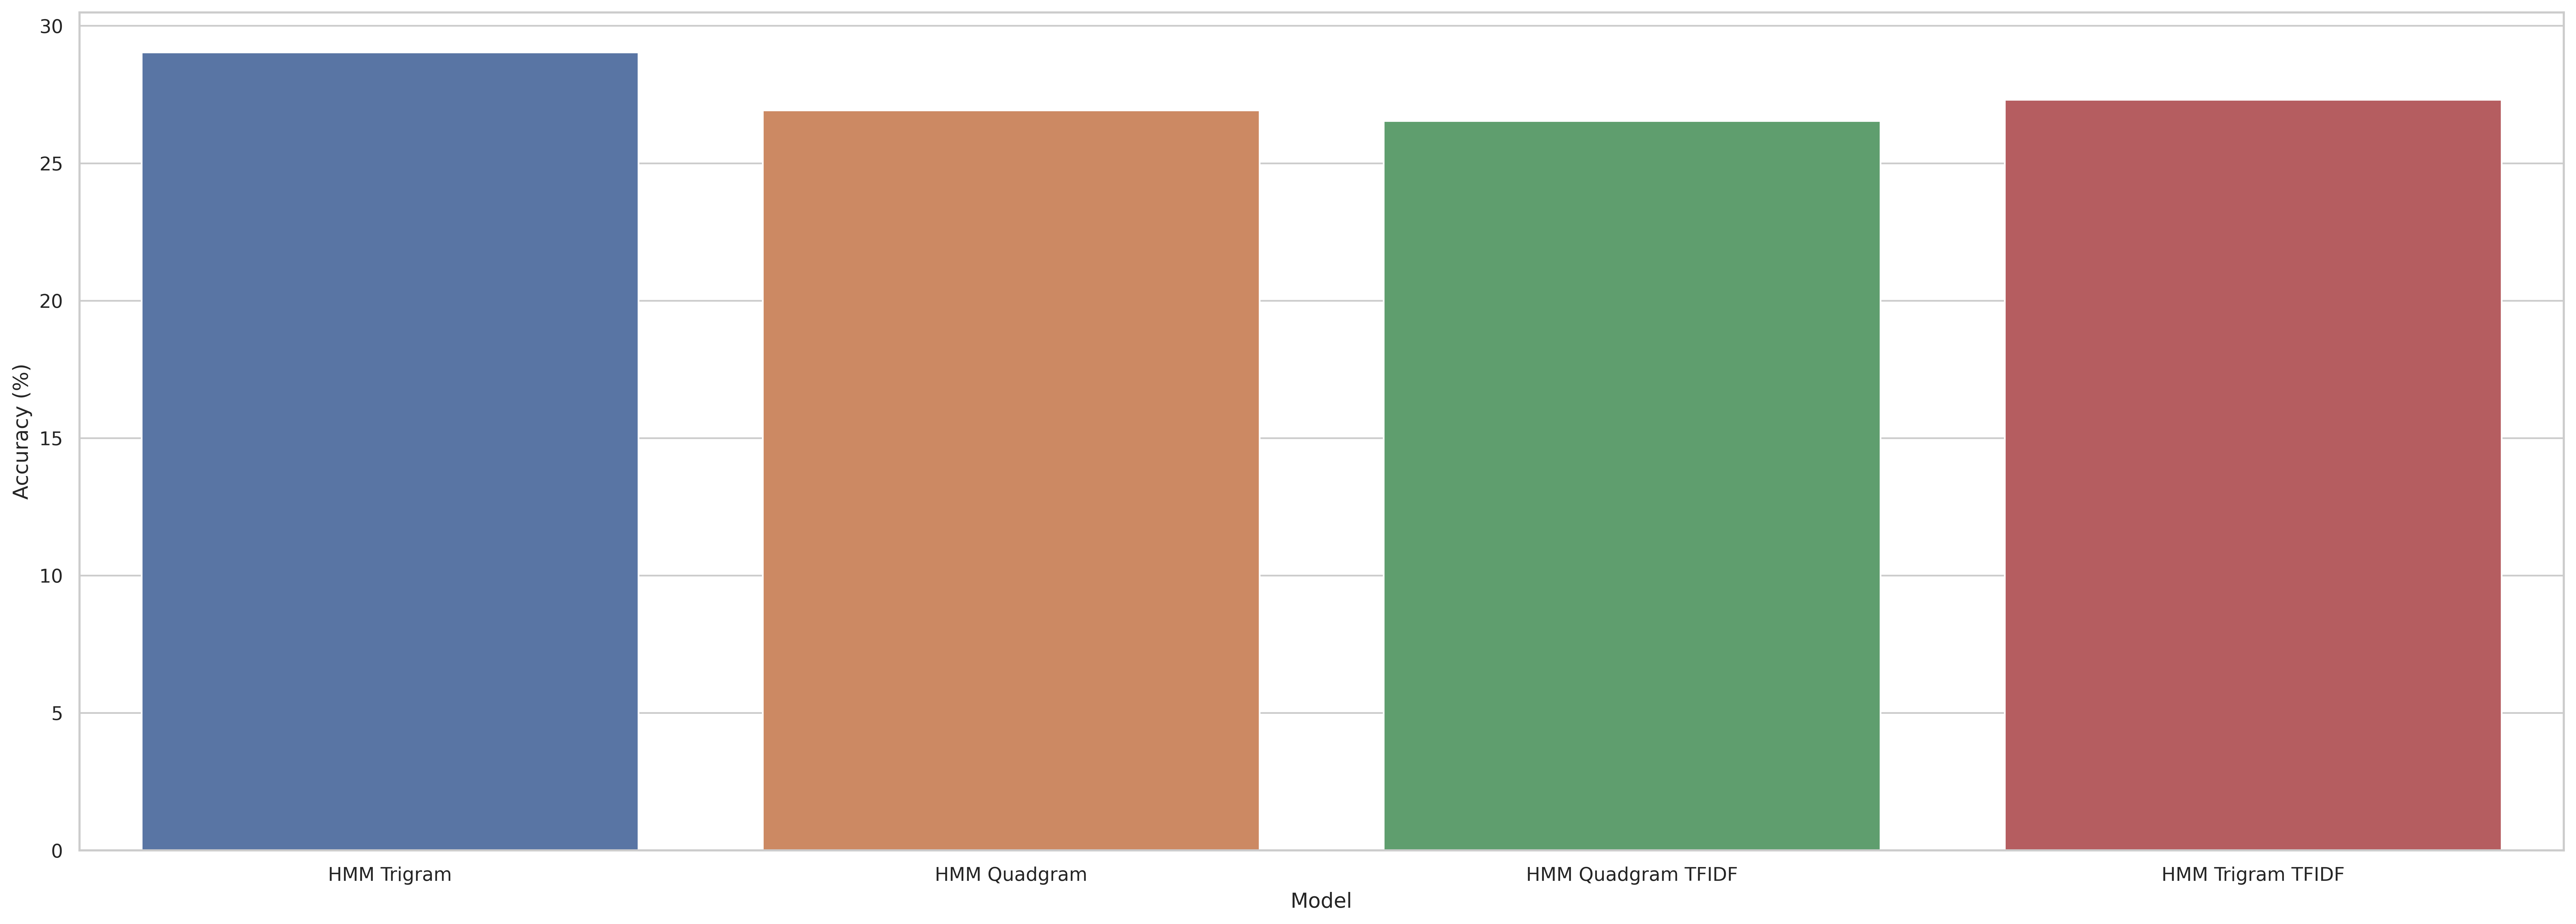

In [31]:
#HMM models
accDict = {
'Model' : ['HMM Trigram', 'HMM Quadgram', 'HMM Quadgram TFIDF', 'HMM Trigram TFIDF'],
'Accuracy' : [hmmTriAcc, hmmQuadAcc, hmmQuadTfidfAcc, hmmTriTfidfAcc]
}
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500,'figure.figsize':(26,9)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Model', y='Accuracy', data=accDict)
ax.set(xlabel='Model', ylabel='Accuracy (%)')
# for key, value in accDict.items():
#     ax.text(key,value, color='black', ha="center")

[Text(0, 0.5, 'Accuracy (%)'), Text(0.5, 0, 'Model')]

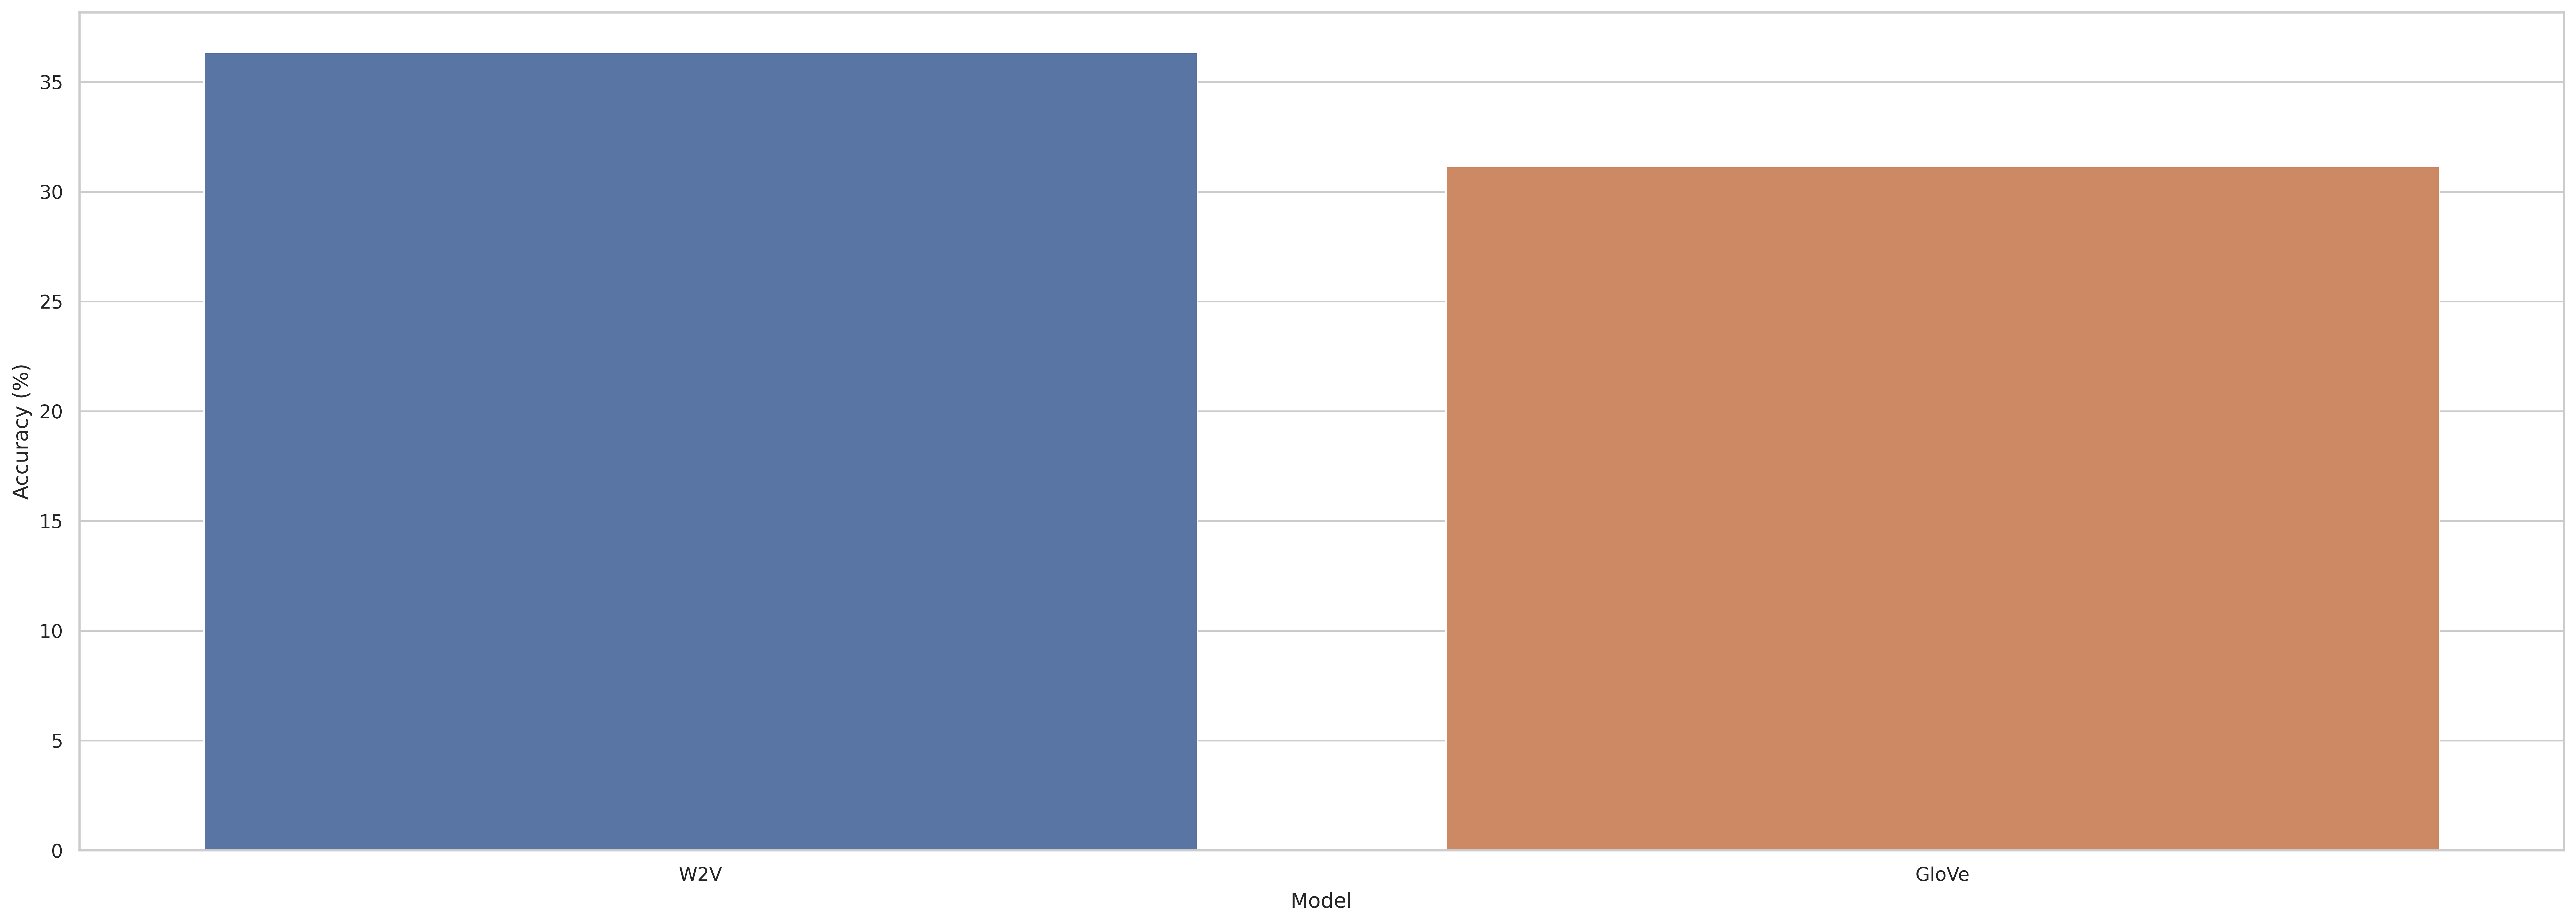

In [53]:
#Word2Vec Models
accDict = {
'Model' : ['W2V', 'GloVe'],
'Accuracy' : [w2vAcc, gloveAcc]
}
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500,'figure.figsize':(26,9)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Model', y='Accuracy', data=accDict)
ax.set(xlabel='Model', ylabel='Accuracy (%)')
# for key, value in accDict.items():
#     ax.text(key,value, color='black', ha="center")

[Text(0, 0.5, 'Accuracy (%)'), Text(0.5, 0, 'Model')]

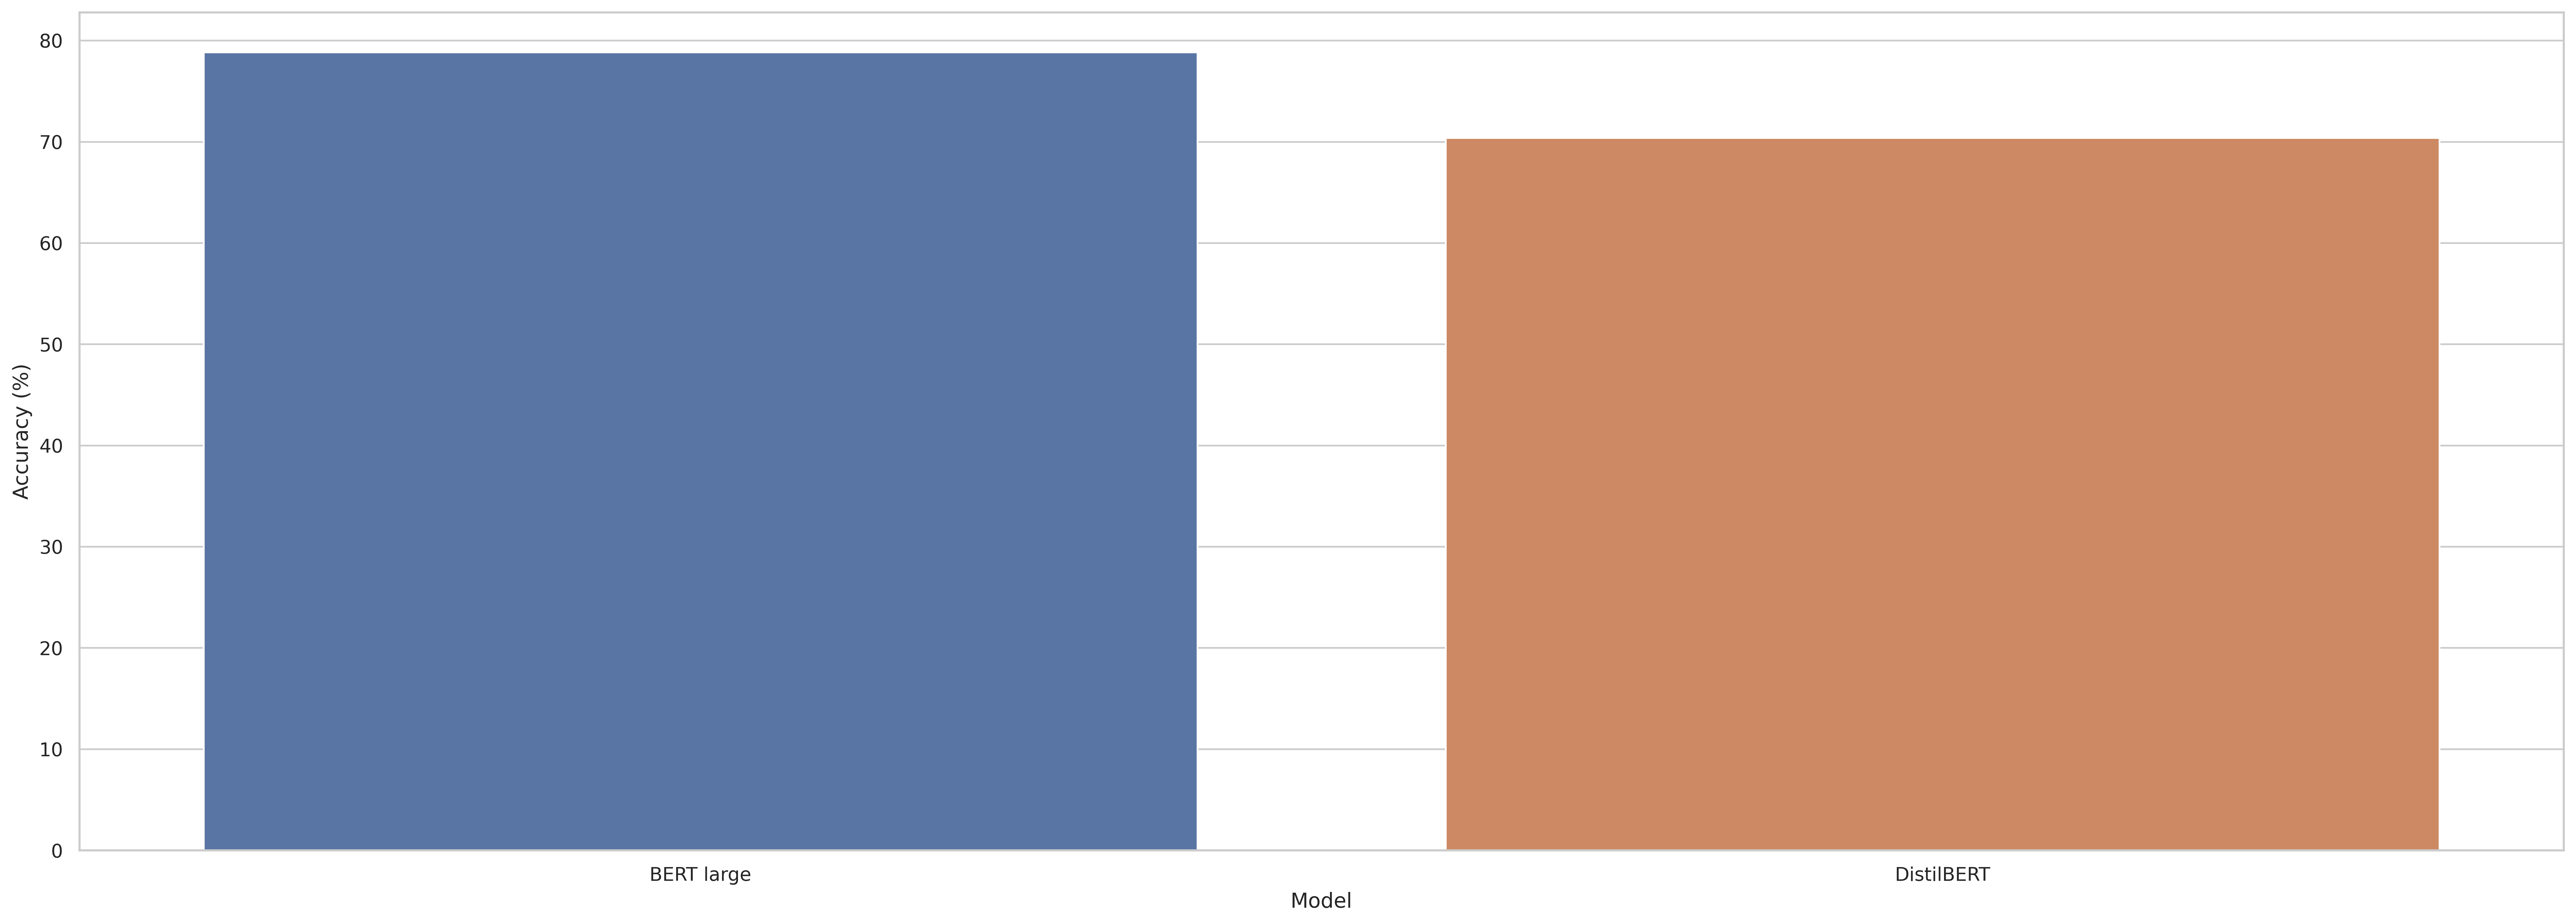

In [54]:
accDict = {
'Model' : ['BERT large', 'DistilBERT'],
'Accuracy' : [bertAcc, distilbertAcc]
}
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500,'figure.figsize':(26,9)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Model', y='Accuracy', data=accDict)
ax.set(xlabel='Model', ylabel='Accuracy (%)')
# for key, value in accDict.items():
#     ax.text(key,value, color='black', ha="center")

[Text(0, 0.5, 'Accuracy (%)'), Text(0.5, 0, 'Model')]

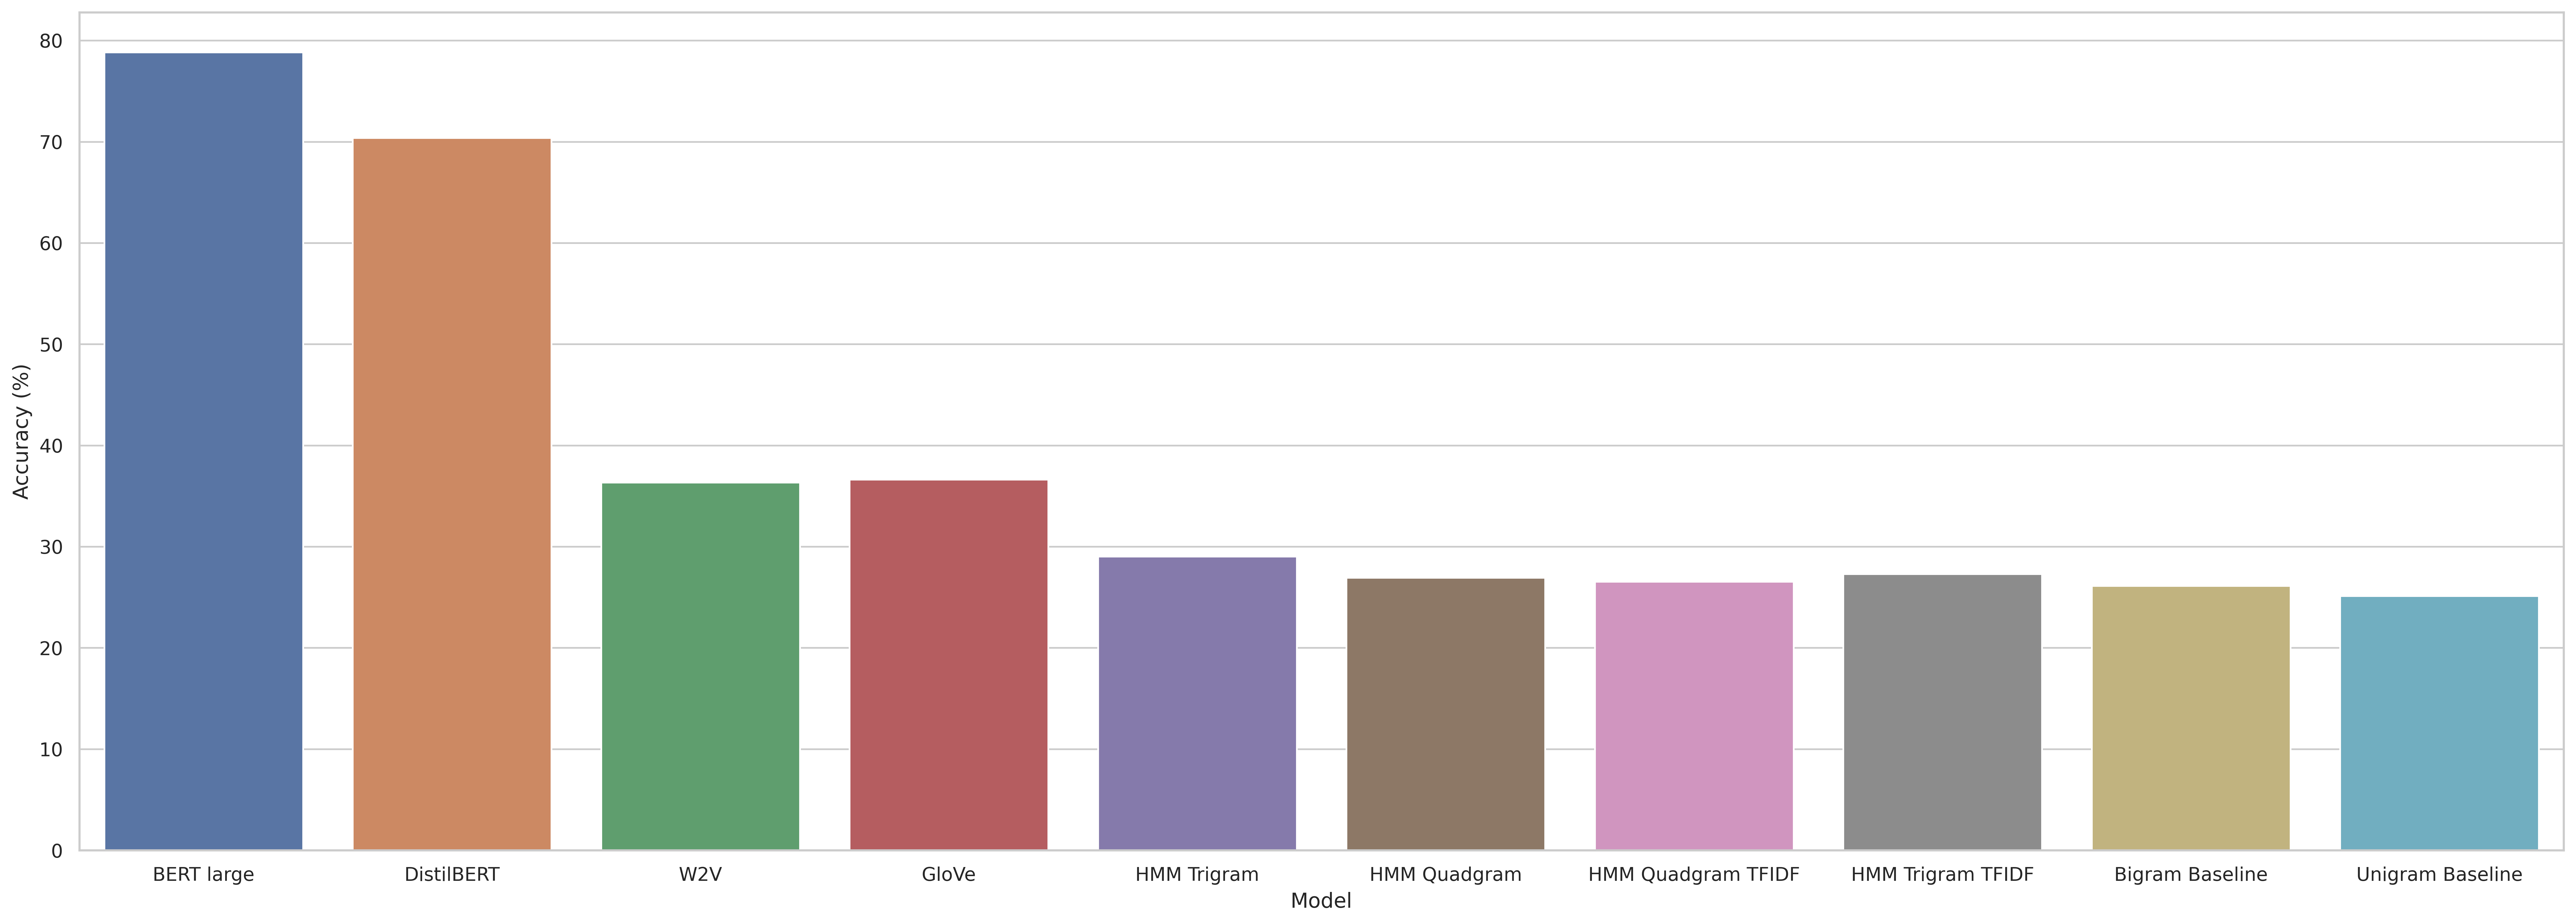

In [13]:
accDict = {
'Model' : ['BERT large', 'DistilBERT' ,'W2V', 'GloVe', 'HMM Trigram', 'HMM Quadgram', 'HMM Quadgram TFIDF', 'HMM Trigram TFIDF', 'Bigram Baseline', 'Unigram Baseline'],
'Accuracy' : [bertAcc, distilbertAcc, w2vAcc, gloveAcc, hmmTriAcc, hmmQuadAcc, hmmQuadTfidfAcc, hmmTriTfidfAcc, 26.1378, 25.1284]
}
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500,'figure.figsize':(26,9)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Model', y='Accuracy', data=accDict)
ax.set(xlabel='Model', ylabel='Accuracy (%)')
# for key, value in accDict.items():
#     ax.text(key,value, color='black', ha="center")

In [14]:
bertInt = (test['answer'] == bert['answers'])
distilbertInt = (test['answer'] == distilbert['answers'])
gloveInt = (test['answer'] == glove['answer'])
w2vInt = (test['answer'] == w2v['answer'])
hmmTriInt = (test['answer'] == hmmTri['answer'])
hmmTriTfidfInt = (test['answer'] == hmmTriTfidf['answer'])
hmmQuadInt = (test['answer'] == hmmQuad['answer'])
hmmQuadTfidfInt = (test['answer'] == hmmQuadTfidf['answer'])

#allInt = len(test[(test['answer'] == hmmQuadTfidf['answer']) & (test[(test['answer'] == hmmQuad['answer']) & (test[(test['answer'] == hmmTriTfidf['answer']) & (test[(test['answer'] == hmmTri['answer']) & (test['answer'] == w2v['answer']) & (test['answer'] == glove['answer']) & (test['answer'] == bert['answers'])])
#allInt
allInt = len(test[bertInt & gloveInt & w2vInt & hmmTriInt ])
allInt

60

In [15]:
bertW2Vglove = len(test[ (test['answer'] == w2v['answer']) & (test['answer'] == glove['answer']) & (test['answer'] == bert['answers'])])
bertW2Vglove

168

In [16]:
bertW2Vhmmtri = len(test[hmmTriInt & (test['answer'] == w2v['answer'])  & (test['answer'] == bert['answers'])])
bertW2Vhmmtri

117

In [17]:
bertGlovehmmtri = len(test[hmmTriInt  & (test['answer'] == glove['answer']) & (test['answer'] == bert['answers'])])
bertGlovehmmtri

108

In [18]:
hmmtriW2Vglove = len(test[hmmTriInt & (test['answer'] == w2v['answer']) & (test['answer'] == glove['answer'])])
hmmtriW2Vglove

65

In [19]:
bertW2V = len(test[(test['answer'] == bert['answers']) & (test['answer'] == w2v['answer']) ])
bertW2V

333

In [20]:
bertHMMtri = len(test[(test['answer'] == bert['answers']) & hmmTriInt ])
bertHMMtri

265

In [21]:
bertGlove = len(test[(test['answer'] == bert['answers']) & (test['answer'] == glove['answer']) ])
bertGlove

314

In [22]:
W2Vglove = len(test[(test['answer'] == glove['answer']) & (test['answer'] == w2v['answer']) ])
W2Vglove

190

In [23]:
W2Vhmmtri = len(test[hmmTriInt & (test['answer'] == w2v['answer'])])
W2Vhmmtri

127

In [24]:
hmmtriGlove = len(test[hmmTriInt & (test['answer'] == glove['answer'])])
hmmtriGlove

125

[Text(0, 0.5, 'Intersection frequency'), Text(0.5, 0, 'Intersection of')]

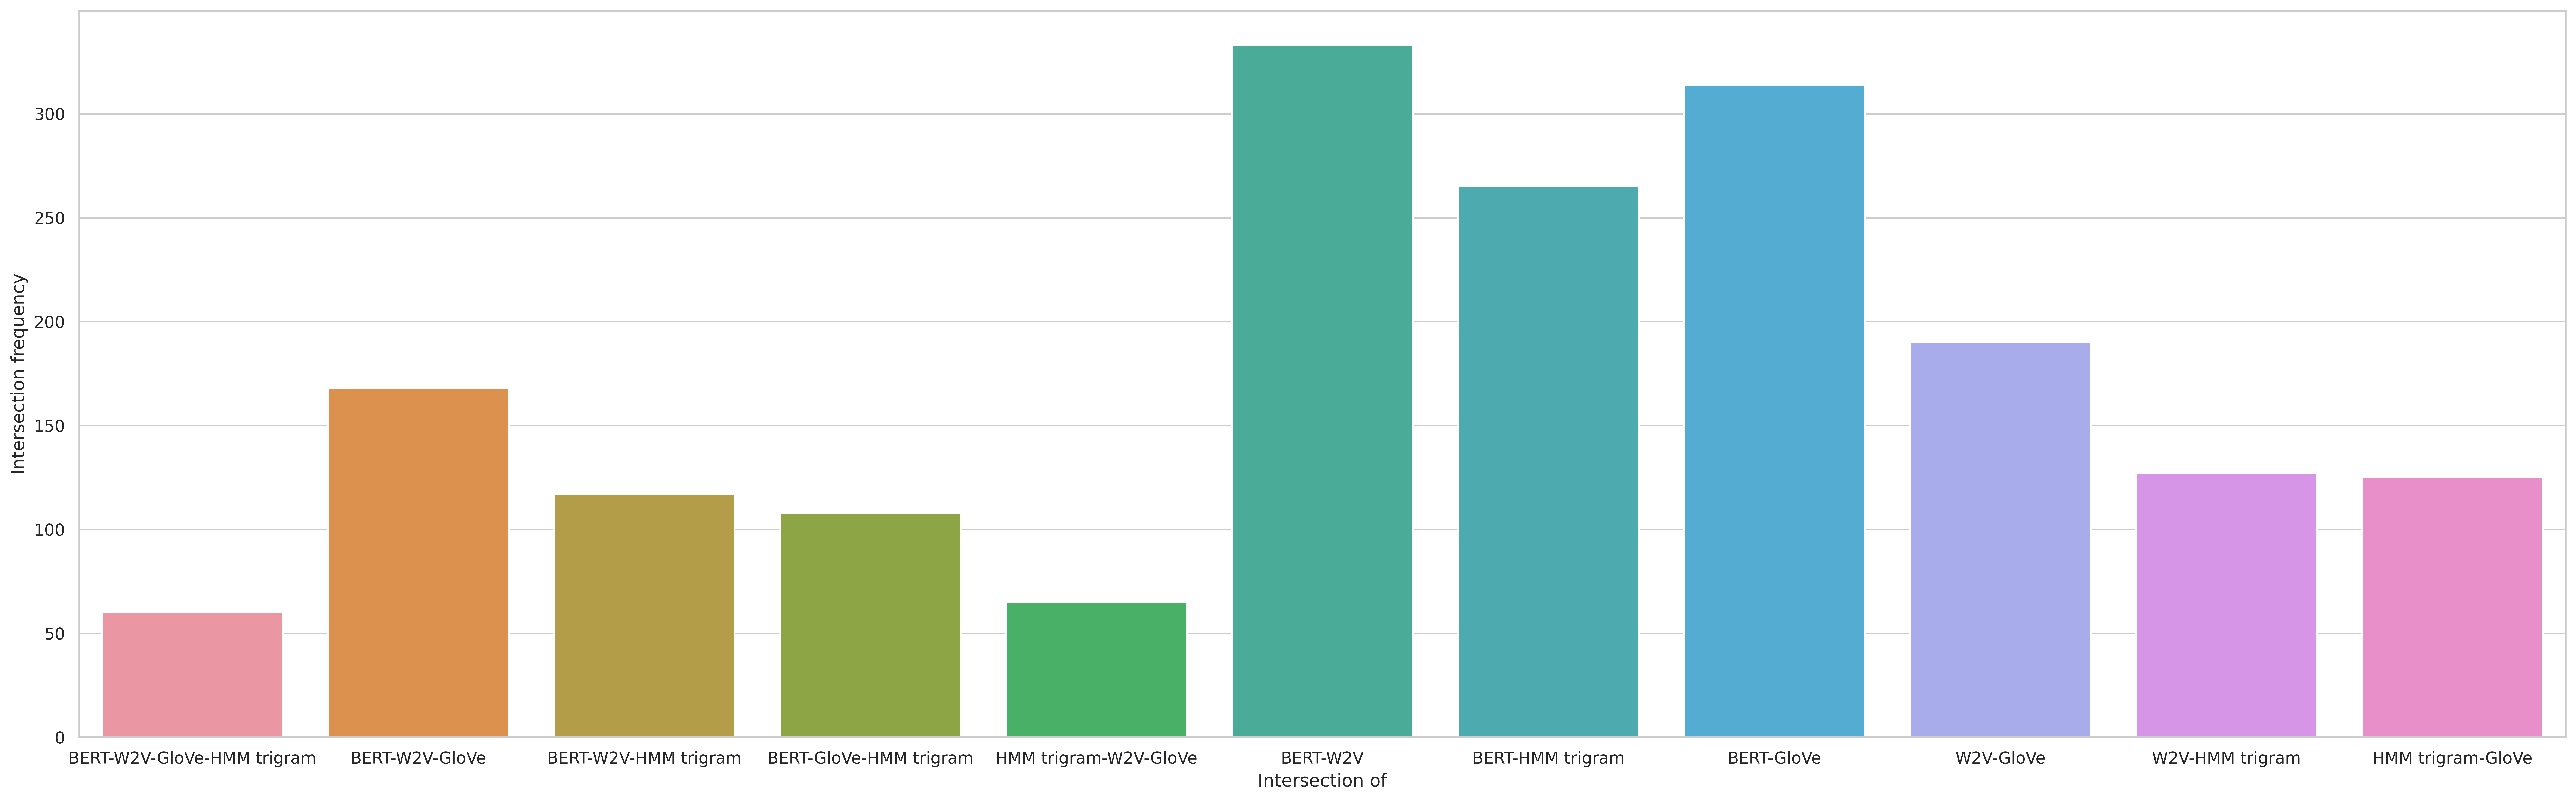

In [25]:
accDict2 = {
'Intersection of' : ['BERT-W2V-GloVe-HMM trigram', 'BERT-W2V-GloVe', 'BERT-W2V-HMM trigram', 'BERT-GloVe-HMM trigram', 'HMM trigram-W2V-GloVe','BERT-W2V','BERT-HMM trigram', 'BERT-GloVe','W2V-GloVe','W2V-HMM trigram','HMM trigram-GloVe'],
'Intersection frequency' : [allInt, bertW2Vglove, bertW2Vhmmtri, bertGlovehmmtri, hmmtriW2Vglove, bertW2V,bertHMMtri,bertGlove,W2Vglove,W2Vhmmtri,hmmtriGlove]
}
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500,'figure.figsize':(30,9)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Intersection of', y='Intersection frequency',data=accDict2)
ax.set(xlabel='Intersection of', ylabel='Intersection frequency')

In [26]:
hmmTri_hmmTriTfidf_hmmQuad = len(test[hmmTriInt & hmmTriTfidfInt & hmmQuadInt])
hmmTri_hmmTriTfidf_hmmQuad

129

In [27]:
hmmTriTfidf_hmmQuad_hmmQuadTfidf = len(test[hmmTriTfidfInt & hmmQuadInt & hmmQuadTfidfInt])
hmmTriTfidf_hmmQuad_hmmQuadTfidf

147

In [28]:
hmmQuadTfidf_hmmTriTfidf_hmmTri = len(test[hmmQuadTfidfInt & hmmTriTfidfInt & hmmTriInt])
hmmQuadTfidf_hmmTriTfidf_hmmTri

133

In [58]:
hmmTri_hmmTriTfidf = len(test[hmmTriInt & hmmTriTfidfInt])
print(hmmTri_hmmTriTfidf)
hmmTriTfidf_hmmQuad = len(test[hmmTriTfidfInt & hmmQuadInt])
print(hmmTriTfidf_hmmQuad)
hmmQuadInt_hmmQuadTfidfInt = len(test[hmmQuadInt & hmmQuadTfidfInt])
print(hmmQuadInt_hmmQuadTfidfInt)
hmmQuadTfidf_hmmTri = len(test[hmmQuadTfidfInt & hmmTriInt])
print(hmmQuadTfidf_hmmTri)
hmmQuad_hmmTri = len(test[hmmQuadInt & hmmTriInt])
print(hmmQuad_hmmTri)
hmmTriTfidf_hmmQuadTfidf = len(test[hmmTriTfidfInt & hmmQuadTfidfInt])
print(hmmTriTfidf_hmmQuadTfidf)

224
148
252
161
162
162


In [30]:
accDict2 = {
'Intersection of' : ['Trigram-Trigram tfidf-Quadgram', 'Trigram tfidf-Quadgram-Quadgram tfidf','Quadgram tfidf-Trigram tfidf-Trigram','Trigram-Trigram tfidf','Trigram tfidf-Quadgram', 'Quadgram-Quadgram tfidf','Quadgram tfidf-Trigram', 'Quadgram-Trigram','Trigram tfidf-Quadgram tfidf'],
'Intersection frequency' : [hmmTri_hmmTriTfidf_hmmQuad, hmmTriTfidf_hmmQuad_hmmQuadTfidf, hmmQuadTfidf_hmmTriTfidf_hmmTri,hmmTri_hmmTriTfidf, hmmTriTfidf_hmmQuad,hmmQuadInt_hmmQuadTfidfInt,hmmQuadTfidf_hmmTri,hmmQuad_hmmTri,hmmTriTfidf_hmmQuadTfidf]
}
sns.set(rc={"figure.dpi":900, 'savefig.dpi':900,'figure.figsize':(39,11)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Intersection of', y='Intersection frequency',data=accDict2)
ax.set(xlabel='Intersection of HMM Models', ylabel='Intersection frequency')

[Text(0, 0.5, 'Intersection frequency'),
 Text(0.5, 0, 'Intersection of HMM Models')]